# Classificazione della qualità dei vini
Per la classificazione delle diverse tipologie di vino abbiamo effettuato un confronto tra i diversi modelli di _apprendimento supervisionato_ con l'obiettivo di trovare il classificatore migliore in grado di determinare il valore più attendibile per il confronto della qualità

Importiamo i moduli e le librerie utili alla realizzazione del sistema

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler

from sklearn.model_selection import GridSearchCV, KFold, train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE
#from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 
from imblearn.metrics import geometric_mean_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from inspect import signature

## Load del dataset
Carichiamo il dataset in locale e lo visualizziamo

In [2]:
df = pd.read_csv("../Dataset/wine_quality.csv")

df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


 <i>Stampa dei vini bianchi con punteggio di qualità uguale a 7</i>

In [3]:

df.loc[(df["type"]=="white")&(df["quality"]==7)].head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
13,white,6.6,0.16,0.40,1.5,0.044,48.0,143.0,0.9912,3.54,0.52,12.4,7
15,white,6.6,0.17,0.38,1.5,0.032,28.0,112.0,0.9914,3.25,0.55,11.4,7
21,white,6.4,0.31,0.38,2.9,0.038,19.0,102.0,0.9912,3.17,0.35,11.0,7
29,white,7.2,0.32,0.36,2.0,0.033,37.0,114.0,0.9906,3.10,0.71,12.3,7
45,white,7.4,0.18,0.31,1.4,0.058,38.0,167.0,0.9931,3.16,0.53,10.0,7


# Pulizia dei dati
## Controllo e pulizia dei valori nulli
Controlliamo la possibile presenza di valori nulli ed eventualmente eliminarli

In [4]:
print(df.isnull().sum())

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64


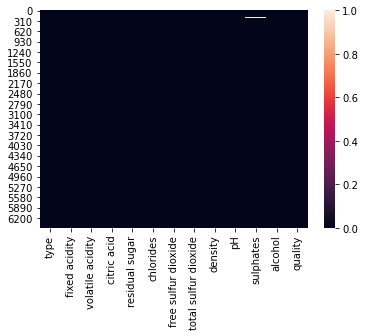

In [5]:
sns.heatmap(df.isnull())

Rimpiazziamo i valori nulli con la mediana della feature associata ad esso

In [6]:
#Replacing null values in fixed acidity with median
df['fixed acidity'].fillna(df['fixed acidity'].median(), inplace=True)
df['fixed acidity'].isna().sum()

#Replacing null values in volatile acidity with mean
df['volatile acidity'].fillna(df['volatile acidity'].mean(), inplace=True)
df['volatile acidity'].isna().sum()

#Replacing null values in citric acid with mean
df['citric acid'].fillna(df['citric acid'].mean(), inplace=True)
df['citric acid'].isna().sum()

#Replacing null values in residual sugar with mean
df['residual sugar'].fillna(df['residual sugar'].mean(), inplace=True)
df['residual sugar'].isna().sum()

#Replacing null values in chlorides with median
df['chlorides'].fillna(df['chlorides'].median(), inplace=True)
df['chlorides'].isna().sum()

#Replacing null values in pH with mean
df['pH'].fillna(df['pH'].mean(), inplace=True)
df['pH'].isna().sum()

#Replacing null values in sulphates with median
df['sulphates'].fillna(df['sulphates'].median(), inplace=True)
df['sulphates'].isna().sum()


0

In [7]:
#Removing outliers in residual sugar
lower = df['residual sugar'].mean()-3*df['residual sugar'].std()
upper = df['residual sugar'].mean()+3*df['residual sugar'].std()
df = df[(df['residual sugar']>lower) & (df['residual sugar']<upper)]

#Removing outliers in free sulfur dioxide
lower = df['free sulfur dioxide'].mean()-3*df['free sulfur dioxide'].std()
upper = df['free sulfur dioxide'].mean()+3*df['free sulfur dioxide'].std()
df = df[(df['free sulfur dioxide']>lower) & (df['free sulfur dioxide']<upper)]

#Removing outliers in total sulfur dioxide
lower = df['total sulfur dioxide'].mean()-3*df['total sulfur dioxide'].std()
upper = df['total sulfur dioxide'].mean()+3*df['total sulfur dioxide'].std()
df = df[(df['total sulfur dioxide']>lower) & (df['total sulfur dioxide']<upper)]

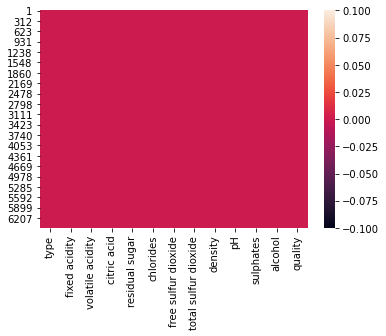

In [8]:
# elimina le righe che contengono valori nulli
#df.dropna(axis='index', how='any', inplace=True)

# heatmap per valori nulli
sns.heatmap(df.isnull())

In [9]:
print('Dimensione del dataset processato: ', df.shape)

Dimensione del dataset processato:  (6430, 13)


### Rimozione delle tuple duplicate

In [10]:
df = df.drop_duplicates()
df.reset_index()
df.shape

(5278, 13)

Come possiamo notare sono state eliminate circa 1200 righe dal dataset

### Visualizzazione statistica delle feature

Raggruppiamo i vini per "type" e visualizziamo una statistica che ci indichi i valori minimi, massimi e medi di ogni feature. Questo ci servirà , successivamente , nella realizzazione delle regole all'interno della nostra KB

In [11]:
result = df.groupby('type').agg({'fixed acidity': ['mean', 'min', 'max'],'volatile acidity': ['mean', 'min', 'max'],
                                'citric acid': ['mean', 'min', 'max'],'residual sugar': ['mean', 'min', 'max'],
                                'chlorides': ['mean', 'min', 'max'],'free sulfur dioxide': ['mean', 'min', 'max'],
                                'total sulfur dioxide': ['mean', 'min', 'max'],'density': ['mean', 'min', 'max'],
                                'pH': ['mean', 'min', 'max'],'sulphates': ['mean', 'min', 'max'],
                                'alcohol': ['mean', 'min', 'max']})

result = result.transpose()
#result.plot(kind='barh', title='Count (quality_label)')
result.head(33)


type                              red       white
fixed acidity        mean    8.311856    6.840855
                     min     4.600000    3.800000
                     max    15.900000   14.200000
volatile acidity     mean    0.529411    0.280675
                     min     0.120000    0.080000
                     max     1.580000    1.100000
citric acid          mean    0.272267    0.334405
                     min     0.000000    0.000000
                     max     1.000000    1.660000
residual sugar       mean    2.519146    5.831974
                     min     0.900000    0.600000
                     max    15.500000   19.600000
chlorides            mean    0.088152    0.045861
                     min     0.012000    0.009000
                     max     0.611000    0.346000
free sulfur dioxide  mean   15.877393   34.329464
                     min     1.000000    2.000000
                     max    72.000000   83.000000
total sulfur dioxide mean   46.647644  136.412245
                     min     6.000000    9.000000
                     max   278.000000  282.000000
density              mean    0.996712    0.993746
                     min     0.990070    0.987110
                     max     1.003690    1.001820
pH                   mean    3.309578    3.195681
                     min     2.740000    2.720000
                     max     4.010000    3.820000
sulphates            mean    0.658513    0.490186
                     min     0.330000    0.220000
                     max     2.000000    1.080000
alcohol              mean   10.430940   10.594068
                     min     8.400000    8.000000
                     max    14.900000   14.200000

## Bilanciamento classe quality prima della normalizzazione

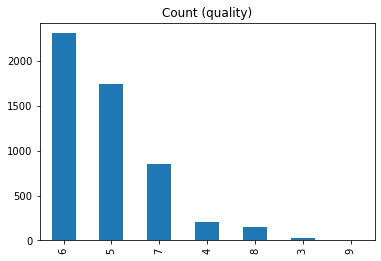

In [12]:
quality_count = df['quality'].value_counts()
quality_count.plot(kind='bar', title='Count (quality)')

## Normalizzazione delle feature numeriche e categoriche


### 1-Hot Encoder

The 'type' column must be 1-hot encoded for classification. 1-hot encoding creates a binary column for each category. Here we use pd.get_dummies() to remove the first category and essentially bring it to one column of 1's and 0's where 1 denotes white wine and 0 denotes not white (red wine).

In [13]:
dummies = pd.get_dummies(df["type"], drop_first=True)
df = pd.concat([df, dummies], axis=1)
df.drop("type", axis=1, inplace=True)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,white
fixed acidity,1.000000,0.213678,0.330001,-0.110387,0.289393,-0.292401,-0.333708,0.492625,-0.269848,0.308504,-0.104582,-0.079849,-0.486987
volatile acidity,0.213678,1.000000,-0.388757,-0.178600,0.367529,-0.360992,-0.405826,0.308677,0.246452,0.227162,-0.068169,-0.266994,-0.645933
citric acid,0.330001,-0.388757,1.000000,0.143484,0.056008,0.148696,0.196010,0.092481,-0.344871,0.061183,-0.010639,0.098193,0.185370
residual sugar,-0.110387,-0.178600,0.143484,1.000000,-0.129263,0.439823,0.502877,0.489904,-0.234278,-0.175557,-0.314914,-0.056616,0.335164
chlorides,0.289393,0.367529,0.056008,-0.129263,1.000000,-0.192930,-0.272484,0.383151,0.026001,0.406638,-0.271485,-0.204264,-0.500057
free sulfur dioxide,-0.292401,-0.360992,0.148696,0.439823,-0.192930,1.000000,0.728142,0.008792,-0.153498,-0.214149,-0.175300,0.082814,0.485239
total sulfur dioxide,-0.333708,-0.405826,0.196010,0.502877,-0.272484,0.728142,1.000000,-0.002841,-0.224104,-0.280617,-0.251082,-0.038090,0.701344
density,0.492625,0.308677,0.092481,0.489904,0.383151,0.008792,-0.002841,1.000000,0.040013,0.296488,-0.687309,-0.336858,-0.449891
pH,-0.269848,0.246452,-0.344871,-0.234278,0.026001,-0.153498,-0.224104,0.040013,1.000000,0.163099,0.096015,0.039954,-0.311429
sulphates,0.308504,0.227162,0.061183,-0.175557,0.406638,-0.214149,-0.280617,0.296488,0.163099,1.000000,-0.021555,0.038303,-0.491477


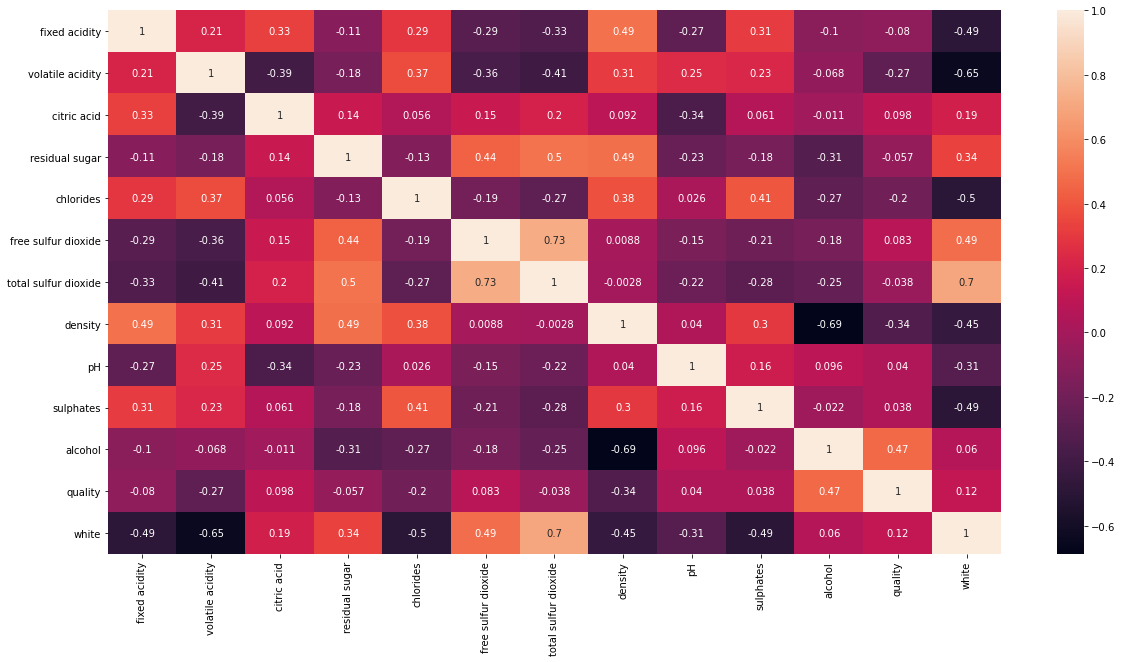

In [14]:
#Checking relationship between features
cor=df.corr()
plt.figure(figsize=(20,10))
sns.heatmap(cor,xticklabels=cor.columns,yticklabels=cor.columns,annot=True)
cor

Trasformiamo la classe 'type' in una feature numerica utilizzando il label encoding

In [15]:
#ord_enc = OrdinalEncoder()
#df["color"] = ord_enc.fit_transform(df[["type"]]) # assume 1 se bianco 0 se rosso

Tracciamo una Heatmap per rappresentare la correlazione tra le features prese in considerazione

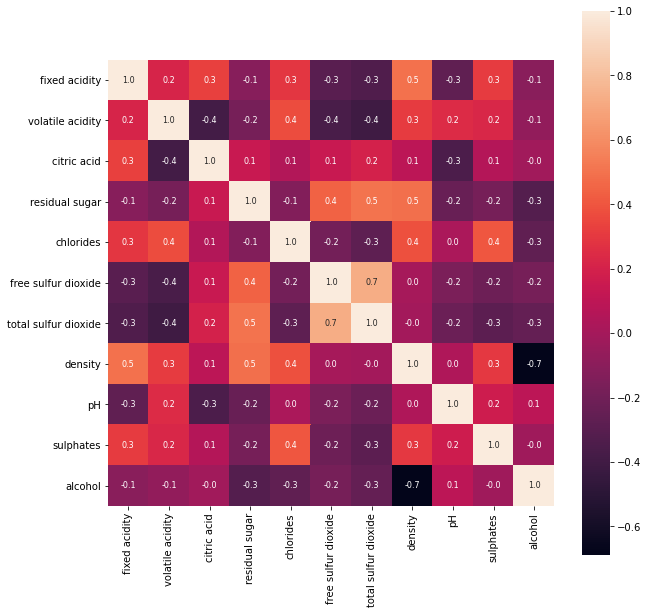

In [16]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
plt.figure(figsize=(10,10))
sns.heatmap(df[features].corr(), cbar=True, square=True, fmt = '.1f', annot = True, annot_kws={'size':8})

Come possiamo notare 'density' ha una correlazione negativa leggermente forte con l'alcol. Perciò, questa feature non verrà considerata nella fase di 'costruzione dei modelli e addestramento'.

### Quality Label
Creiamo la quality label basata sulla già esistente colonna 'quality'

- bad per un punteggio minore o uguale di 5
- good per più di 5

In [17]:
df['quality_label'] = df.quality.apply(lambda q: 'bad' if q <= 6 else 'good')

## Distribuzione della classe quality

Osserviamo la correlazione tra la qualità del vino e la percentuale alcolica

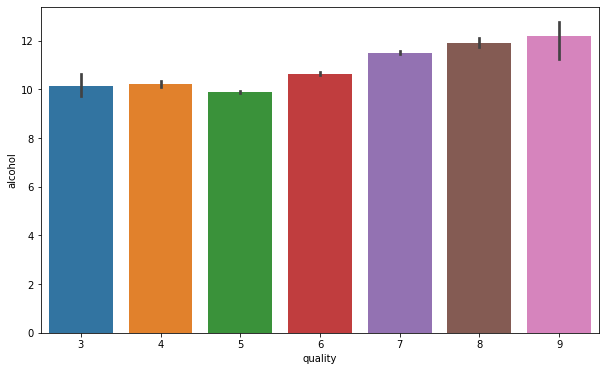

In [18]:
fig = plt.figure(figsize = (10,6))
sns.barplot(x = 'quality', y = 'alcohol', data = df)

Come possiamo notare la qualità di un vino cresce all'aumentare del grado alcolico.

Osserviamo ora il bilanciamento della classe quality_label, cioè il target della classificazione:

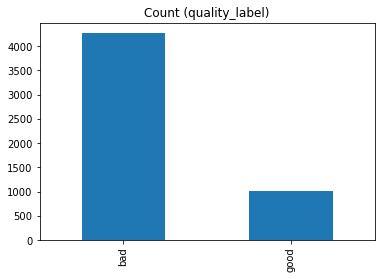

In [19]:
quality_count = df['quality_label'].value_counts()
quality_count.plot(kind='bar', title='Count (quality_label)')

In [20]:
df.quality_label.value_counts()

bad     4273
good    1005
Name: quality_label, dtype: int64

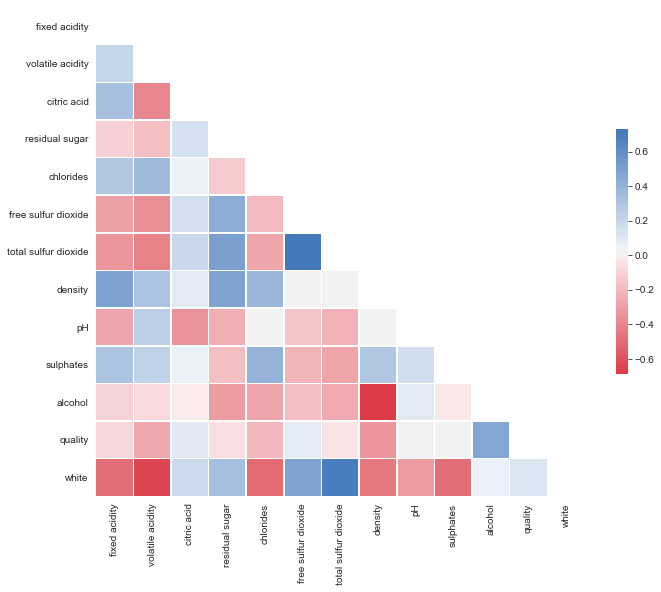

In [21]:
import numpy as np
# chiamo .corr() per calcolare la correlazione a coppie tra le feature del dataframe
corr = df.corr()

# visualizzazione dei dati
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.set_style(style = 'white')
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
        square=True,
        linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [22]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,white,quality_label
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1,bad
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1,bad
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1,bad
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6,1,bad
9,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6,1,bad


Utilizziamo la classe LabelEncoder per poter convertire la colonna  'quality_label' in feature numerica

In [23]:
ord_enc = OrdinalEncoder()
df["quality_label"] = ord_enc.fit_transform(df[["quality_label"]]) # assume 1 se good 0 se bad
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,white,quality_label
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,1,0.0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,1,0.0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,1,0.0
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6,1,0.0
9,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6,1,0.0


# Costruzione dei modelli & Addestramento
## Preparazione del dataset
Prenderemo come target la colonna 'quality_label' per una maggiore accuratezza. Avendo già convertito questo attributo categorico utilizzando la classe LabelEncoder, possiamo procedere alla costruzione dei vari modelli di classificazione ed addestramento.

In [24]:
print(df['quality_label'].value_counts())

0.0    4273
1.0    1005
Name: quality_label, dtype: int64


## Divisione del dataset

Dividiamo ora il dataset in train e test considerando soltanto le feature che hanno più importanza, infatti la densità non verrà considerata per questo esperimento. Così facendo viene ridotta la complessità dei vari modelli.

In [25]:
X = df.drop(['quality_label','quality','density'], axis = 1)
y = df['quality_label']

### Applicazione di SMOTE per il bilanciamento dei dati

SMOTE is a technique used by researched in order to remove the data imbalance. In the given
research data, there are more instances of white wine samples and lesser instances of red wine
samples, thus the data is imbalanced and needs to be balanced in order to remove the bias.
Furthermore, there are more instances found between the quality value of 3 to 9 and no instances
are found beyond these values. In another setting since the values above 6 are deemed to be
wine with good quality and those below the value of 6 are deemed to be wine with low quality,
therefore, there are more instances are values above 6 and less of those which have values below
less

SMOTE (synthetic minority oversampling technique) un'operazione di oversampling sul set di training, in modo da risolvere il problema dello sbilanciamento dei dati

In [26]:
# Applicazione di SMOTE per bilanciare le classi
oversample = SMOTE()
X1, y1 = oversample.fit_resample (X, y)

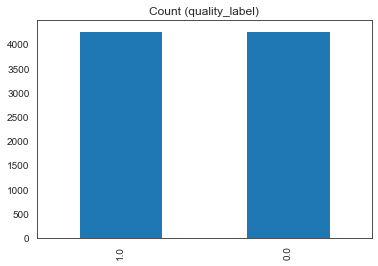

In [27]:
quality_count = y1.value_counts()
quality_count.plot(kind='bar', title='Count (quality_label)')

Colonna quality dopo l'applicazione di SMOTE

### Train e test set

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size = 0.2,random_state = 11)

## Naive Bayes
Tramite questo classificatore possiamo calcolare la probabilità che un determinato evento avvenga all'interno del dataset.

Creiamo un pipeline dove vengono svolte in maniere consequenziale le seguenti azioni:

- Classifier è il modello che verrà utilizzato per l'apprendimento, in questo caso Naive Bayes

La costruzione del classificatore avviene nel seguente modo: si crea un oggetto della classe GaussianNB e successivamente viene chiamato il metodo fit, specificando come argomenti le osservazioni e le corrispondenti etichette. Infine invochiamo il metodo predict passando come argomento una lista di oggetti da classificare.

In [29]:
pipeline = Pipeline(steps = [['classifier', GaussianNB()]]) 

Istanziamo un oggetto della classe StratifiedKFold che ci permetterà di andare a definire un tipo di Cross Validation

In [30]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=5)

### Hyperparameter tuning e Ricerca dei parametri migliori

In [31]:
# in param_grid sono definiti gli iperparametri
param_grid = {}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 1,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili
# fase di training del modello
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


Le metriche che considereremo per ogni modello saranno:

- accuracy
- recall
- precision
- f1
- matthews correlation coefficent
- geometric mean score

accuracy: 0.7140350877192982
precision: 0.7296441648588747
recall: 0.7138821707632034
f1: 0.7089969462062485
matthews_corrcoef: 0.44324617306015884
geometric_mean_score: 0.7138821707632034


[]

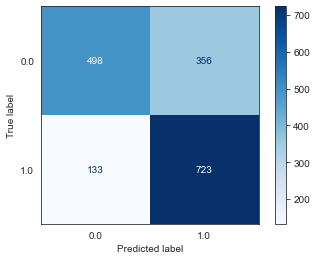

In [32]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [33]:
scoring_list = []
scoring_list.append(dict([
    ('Model', 'Naive Bayes'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

## Random Forest
Useremo il Random Forest della libreria scikit-learn, che calcola la media della previsione probabilistica di tutti gli alberi nella foresta per la previsione finale invece di prendere i voti di previsione effettivi e quindi calcolarne la media

In [34]:
pipeline = Pipeline(steps = [['classifier', RandomForestClassifier(max_depth=12, random_state=5)]])

In [35]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

### Hyperparameter Tuning

In [36]:
# in param_grid sono definiti gli iperparametri
param_grid = {
                'n_estimators': [50,100, 200],
                'max_depth': [6,10, 12],
                'random_state': [0,4,5,11,101]
                }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

### Ricerca dei parametri migliori

In [37]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 45 candidates, totalling 135 fits
Best parameters: {'classifier__max_depth': 12, 'classifier__n_estimators': 200, 'classifier__random_state': 101}
Cross-validation score: 0.8513757516523929


accuracy: 0.8707602339181286
precision: 0.8756281006513533
recall: 0.8706937118343584
f1: 0.8703255911627463
matthews_corrcoef: 0.7463055001800273
geometric_mean_score: 0.8706937118343584


[]

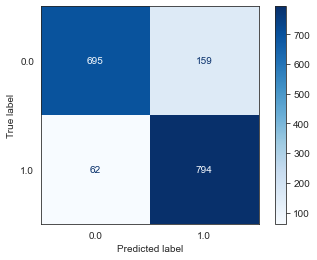

In [38]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [39]:
scoring_list.append(dict([
    ('Model', 'RandomForest'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

## KNN

l KNN è un algoritmo di classificazione che mira a determinare la classe di appartenenza di un dato di input
cercando tra tutti gli esempi di addestramento quello più vicino al dato di input in base alla metrica
desiderata, come ad esempio la distanza euclidea

In [40]:
pipeline = Pipeline(steps = [['classifier',KNeighborsClassifier()]]) 

In [41]:
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

### Hyperparameter tuning

In [42]:
# in param_grid sono definiti gli iperparametri
param_grid = {
         'n_neighbors': [10, 11, 12, 13] ,
         'weights': ['distance'],
         'algorithm' : ['ball_tree', 'kd_tree' ],
         'leaf_size': [12, 11, 13],
         'p': [1,2]
}


new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

### Ricerca dei parametri migliori

In [43]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best parameters: {'classifier__algorithm': 'ball_tree', 'classifier__leaf_size': 12, 'classifier__n_neighbors': 10, 'classifier__p': 1, 'classifier__weights': 'distance'}
Cross-validation score: 0.8079281983598255


accuracy: 0.8134502923976609
precision: 0.8441258983995228
recall: 0.8132756243297073
f1: 0.8091391651163677
matthews_corrcoef: 0.6566772591437346
geometric_mean_score: 0.8132756243297073


[]

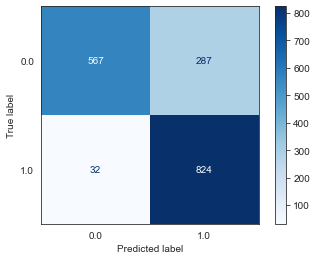

In [44]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [45]:
scoring_list.append(dict([
    ('Model', 'KNN'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

## Support Vector Machine

The support vector machine (SVM) is the most popular and most widely used machine learning algorithm. It is a supervised learning model that can perform classification and regression tasks. However, it is primarily used for classification problems in machine learning. The SVM algorithm aims to create the best line or decision boundary that can separate n-dimensional space into classes. So we can put the new data points easily in the correct groups. This best decision boundary is called a hyperplane.

In [46]:
pipeline = Pipeline(steps = [['classifier',SVC(kernel=None,
                                                  gamma=None, 
                                                  C=None)]])
stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

### Hyperparameter tuning

In [47]:
# in param_grid sono definiti gli iperparametri
param_grid = {'C': [0.08, 0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf'] # linear
              }

new_params = {'classifier__' + key: param_grid[key] for key in param_grid}

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=new_params,
                           scoring='accuracy',
                           cv=stratified_kfold,
                           verbose = 5,
                           n_jobs=-1) # utilizzerà tutti i processori disponibili

### Ricerca dei parametri migliori

In [48]:
# troviamo il modello migliore
grid_search.fit(X_train, y_train.values.ravel())

cv_score = grid_search.best_score_
best_params = grid_search.best_params_

print(f'Best parameters: {best_params}')
print(f'Cross-validation score: {cv_score}')

# effetuamo la predizione sul set di test
y_test_predict = grid_search.predict(X_test)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best parameters: {'classifier__C': 10, 'classifier__gamma': 0.1, 'classifier__kernel': 'rbf'}
Cross-validation score: 0.8616153802394475


accuracy: 0.8853801169590644
precision: 0.893438432398002
recall: 0.8852965155726762
f1: 0.8847742171481379
matthews_corrcoef: 0.778692383667199
geometric_mean_score: 0.8852965155726762


[]

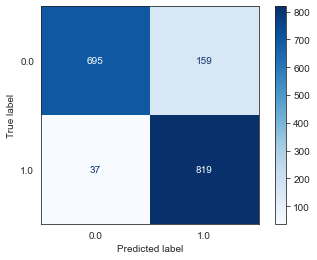

In [49]:
# calcoliamo le metriche di valutazione
accuracy = accuracy_score(y_test, y_test_predict)
precision = precision_score(y_test, y_test_predict, average='macro')
recall = recall_score(y_test, y_test_predict, average='macro')
f1 = f1_score(y_test, y_test_predict, average='macro')
mcc = matthews_corrcoef(y_test, y_test_predict)
gm = geometric_mean_score(y_test, y_test_predict, average='macro')
ConfusionMatrixDisplay.from_predictions(y_test, 
                                        y_test_predict, 
                                        cmap=plt.cm.Blues)

print(f'accuracy: {accuracy}')
print(f'precision: {precision}')
print(f'recall: {recall}')
print(f'f1: {f1}')
print(f'matthews_corrcoef: {mcc}')
print(f'geometric_mean_score: {gm}')

plt.plot()

In [50]:
scoring_list.append(dict([
    ('Model', 'SVM'),
    ('Train Accuracy', round(cv_score, 3)),
    ('Test Accuracy', round(accuracy, 3)),
    ('Precision', round(precision, 3)),
    ('Recall', round(recall, 3)),
    ('F1', round(f1, 3)),
    ('Matthews Corrcoef', round(mcc,3)),
    ('Geometric Mean Score', round(gm, 3))
     ]))

# Confronto dei vari modelli

In [51]:
results = pd.DataFrame(data=scoring_list)
results = results[['Model',
                   'Train Accuracy',
                   'Test Accuracy',
                   'Precision',
                   'Recall',
                   'F1',
                   'Matthews Corrcoef',
                   'Geometric Mean Score']]

results = results.sort_values(by='Recall', ascending=False)

print(results)

          Model  Train Accuracy  Test Accuracy  Precision  Recall     F1  \
3           SVM           0.862          0.885      0.893   0.885  0.885   
1  RandomForest           0.851          0.871      0.876   0.871  0.870   
2           KNN           0.808          0.813      0.844   0.813  0.809   
0   Naive Bayes           0.715          0.714      0.730   0.714  0.709   

   Matthews Corrcoef  Geometric Mean Score  
3              0.779                 0.885  
1              0.746                 0.871  
2              0.657                 0.813  
0              0.443                 0.714  


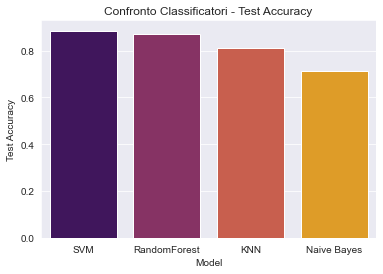

In [52]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Test Accuracy'],
                palette = 'inferno').set(title = "Confronto Classificatori - Test Accuracy")

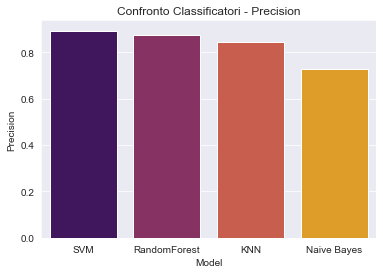

In [53]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Precision'],
                palette = 'inferno').set(title = "Confronto Classificatori - Precision")

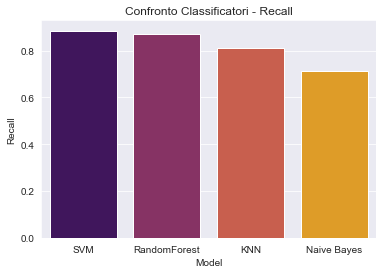

In [54]:
with sns.axes_style("darkgrid"):
    sns.barplot(data = results,
                x=results['Model'],
                y=results['Recall'],
                palette = 'inferno').set(title = "Confronto Classificatori - Recall")

Come possiamo vedere dai grafici precedenti, il modello migliore è risultato il Support Vector Machine (accuracy dell'88%) seguito dal Random Forest (accuracy del 87%) con indice di profondità pari a 12. Nel complesso quasi tutti i modelli si sono comportati circa in egual modo, a differenza del Naive Bayes che ha restiuito un Accuracy dell'70% circa